# Notebook 3: Stochastic Inversion with Probabilistic Spin Logic (P-bits)
 
**Description:** This notebook introduces the core innovation of this thesis: Stochastic Inversion using P-bits. We demonstrate how P-bits overcome the limitations of deterministic methods (local minima) by implementing Langevin Dynamics with Simulated Annealing. This approach is designed to be mapped onto FPGA hardware for massive parallelism.

## 1. The Limitation of Deterministic Inversion

In Notebook 2, we used L-BFGS to minimize the objective function $\Phi(\mathbf{m})$. While efficient, gradient-based methods suffer from a major drawback: **Trapping in Local Minima.**

The geophysical inverse problem is highly non-linear and non-convex. The "Energy Landscape" looks like a rugged mountain range with many small valleys (local minima) and one deep canyon (global minimum).

* **L-BFGS (The Ball):** Rolls downhill and stops at the bottom of the *nearest* valley. If the starting point is far from the true solution, it gets stuck.
* **Stochastic Methods (The Drunk Hiker):** Adds random noise to the movement. This allows the algorithm to "jump" out of shallow valleys and explore the landscape to find the global minimum.

## 2. P-bits: Hardware-Native Probabilistic Spins

A P-bit (Probabilistic Bit) is an unstable hardware device that fluctuates between 0 and 1. Unlike a standard bit (stable) or a Q-bit (quantum superposition), a P-bit is a classical entity governed by **Stochastic Physics**.

### 2.1. The Activation Function

The output state $m_i$ of a P-bit $i$ is updated according to:

$$
m_i(t+\Delta t) = \text{sgn} \left( \text{rand}(-1, 1) + \tanh(\beta I_i) \right)
$$

Or, in terms of probability:
$$
P(m_i = +1) = \sigma(I_i) = \frac{1}{1 + e^{-2 I_i}}
$$

Where $I_i$ is the input signal (synaptic current). In our inversion framework, this input corresponds to the **Gradient of the Objective Function**.

## 3. Algorithm: Langevin Dynamics

To solve the continuous parameter optimization problem (conductivity values are continuous, not binary), we implement a variant of P-bit dynamics known as **Overdamped Langevin Dynamics**.

The update rule for model parameter $m$ is:

$$
m_{new} = m_{old} - \eta \nabla \Phi(m) + \sqrt{2 T} \cdot \xi
$$

Where:
* **$-\nabla \Phi(m)$:** The deterministic force (Gradient) pulling towards the minimum.
* **$\eta$:** Learning Rate (Step size).
* **$T$:** Temperature (Noise magnitude).
* **$\xi$:** Random Gaussian noise $\mathcal{N}(0, 1)$.

This equation allows us to simulate the behavior of a P-bit network on a standard CPU for validation, before FPGA implementation.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

import time


from pymtinv.forward import MT2DForward
from pymtinv.backward import MT2DGradient
from pymtinv.mesh import create_padded_mesh
from pymtinv.visualization import MT2DVisualizer

# İki otomatik fonksiyonu da çağırıyoruz
from pymtinv.utils import (
    find_optimal_beta_fast,
    tune_pbit_hyperparameters,
    pbit_optimizer,
)


## 4. Setup: The Problem

We create a more complex model than in Notebook 2 to challenge the optimizer. We include a resistive target hidden below a conductive overburden (a classic difficult case in MT).

In [12]:
def create_complex_model_log(mesh, n_pad_y):
    """
    Test için LOGARİTMİK (log10) yer altı modeli oluşturur.
    """
    # Arkaplan: 100 ohm-m -> 0.01 S/m -> log10 = -2.0
    sigma_log = np.ones((mesh.Ny, mesh.Nz)) * -2.0

    # Core bölgesine iletken blok (Kırmızı)
    # 10 ohm-m -> 0.1 S/m -> log10 = -1.0
    center_y, center_z = mesh.Ny // 2, mesh.Nz // 2

    # Blok boyutları
    sigma_log[center_y - 4 : center_y + 4, center_z - 4 : center_z + 4] = -1.0

    return sigma_log

N_PAD = 5
mesh = create_padded_mesh(10000, 5000, 500, 250, 1.4, N_PAD, N_PAD)
frequencies = np.logspace(2, -2.3, 10)

print(" [1/5] Veri hazırlanıyor...")
sigma_true_log = create_complex_model_log(mesh, N_PAD)
fwd = MT2DForward(mesh)
Z_true, _ = fwd.solve_te(frequencies, 10**sigma_true_log)

Z_obs, data_std = [], []
np.random.seed(42)
for f in frequencies:
    val = Z_true[f]
    noise = 0.05 * np.abs(val)
    Z_obs.append(
        val
        + noise * (np.random.randn(*val.shape) + 1j * np.random.randn(*val.shape))
    )
    data_std.append(noise)

grad_engine = MT2DGradient(fwd, Z_obs, data_std)
m_init = (np.ones((mesh.Ny, mesh.Nz)) * -2.0).flatten()


 Mesh Oluşturuldu: 30x25 hücre.
 Toplam Boyut: 25.3 km x 8.8 km
 [1/5] Veri hazırlanıyor...


## 5. Hyperparameter Tuning (Auto-Tuning)

Stochastic methods are sensitive to parameters like `Learning Rate` and `Initial Temperature`. Instead of guessing, we use our **Auto-Tuning** utility (Grid Search) to find the best parameters for a short run.

In [13]:
# 2. AUTO-BETA (Tikhonov Ayarı)
target_phi = (len(frequencies) * mesh.Ny * 2) / 2.0
optimal_beta = find_optimal_beta_fast(
    grad_engine, frequencies, mesh, m_init, target_phi
)

# 3. AUTO-PBIT (Hiperparametre Ayarı)
# Burada optimal_beta'yı da kullanıyoruz ki şartlar eşit olsun
best_lr, best_t_start = tune_pbit_hyperparameters(
    grad_engine, frequencies, mesh, m_init, beta=optimal_beta
)


--- Otomatik Beta Taraması (Hedef Phi ≈ 300) ---
Beta       | Phi_d (10 iter) | Fark       | Durum
------------------------------------------------------------
100.0      | 363.3           | 63.3       | Makul (*)
50.0       | 322.1           | 22.1       | Makul (*)
10.0       | 300.0           | 0.0        | Overfit? (*)
5.0        | 307.2           | 7.2        | Makul
1.0        | 313.1           | 13.1       | Makul
0.5        | 314.2           | 14.2       | Makul
0.1        | 315.3           | 15.3       | Makul
------------------------------------------------------------
 >>> SEÇİLEN OPTİMUM BETA: 10.0

--- P-bit Hiperparametre Taraması (Auto-Tuning) ---
LR         | T_start    | Phi (300 iter)  | Durum
-------------------------------------------------------
0.0005     | 0.01       | 619.79          | İyi Aday
0.0005     | 0.1        | 1065.79         | Yavaş
0.0005     | 0.5        | 1344.94         | Yavaş
0.001      | 0.01       | 411.50          | İyi Aday
0.001      | 0.1

## 6. Running the P-bit Optimizer

We now run the full optimization. Notice the **Simulated Annealing** schedule: we start with high noise (exploration) and gradually cool down to zero noise (exploitation).

This simulates the physics of crystallization, allowing the model to settle into the global minimum.

In [15]:
FINAL_STEPS = 3000
print(f"\n [4/5] Final P-bit Simülasyonu Başlıyor ({FINAL_STEPS} adım)...")
start_time = time.time()

m_final, hist, final_phi = pbit_optimizer(
    grad_engine,
    m_init,
    frequencies,
    mesh,
    n_steps=FINAL_STEPS,
    lr=best_lr,
    t_start=best_t_start,
    t_end=0.0001,
    beta=optimal_beta,
)

print(
    f" İşlem Tamamlandı: {time.time() - start_time:.2f}s | Final Phi: {final_phi:.1f}"
)


 [4/5] Final P-bit Simülasyonu Başlıyor (3000 adım)...
 İşlem Tamamlandı: 473.66s | Final Phi: 353.5


## 7. Analysis of Results

We compare the True Model with the P-bit Recovered Model. We also observe the convergence history to see the effect of thermal noise.

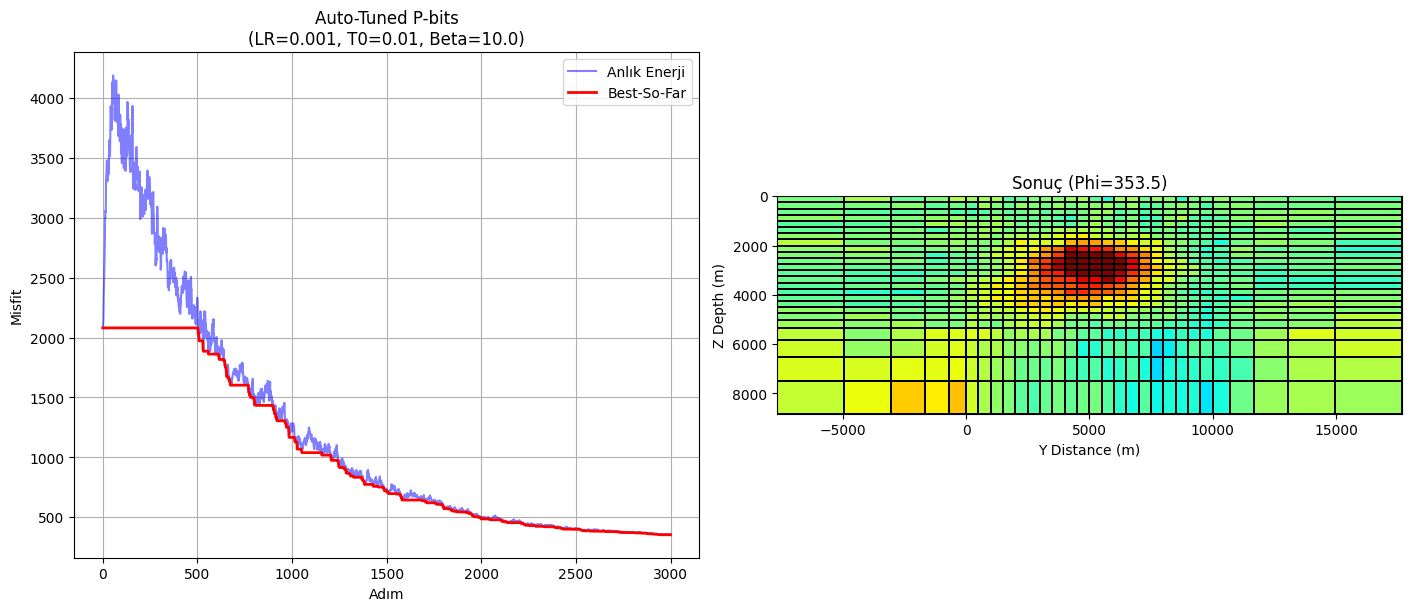

In [16]:
# 5. GÖRSELLEŞTİRME
plt.figure(figsize=(14, 6), constrained_layout=True)

# Enerji Grafiği
ax1 = plt.subplot(1, 2, 1)
ax1.plot(hist, "b-", alpha=0.5, label="Anlık Enerji")
ax1.plot(np.minimum.accumulate(hist), "r-", linewidth=2, label="Best-So-Far")
ax1.set_title(
    f"Auto-Tuned P-bits\n(LR={best_lr}, T0={best_t_start}, Beta={optimal_beta})"
)
ax1.set_xlabel("Adım")
ax1.set_ylabel("Misfit")
ax1.legend()
ax1.grid(True)

# Model
ax2 = plt.subplot(1, 2, 2)
# m_final zaten logaritmik geliyor
MT2DVisualizer.plot_model(
    mesh,
    m_final.reshape((mesh.Ny, mesh.Nz)),
    ax=ax2,
    title=f"Sonuç (Phi={final_phi:.1f})",
    grid_lines=True,
    vmin=-3,
    vmax=-1,
)

plt.show()

 Mesh Oluşturuldu: 32x30 hücre.
 Toplam Boyut: 26.6 km x 10.1 km

 [1/4] Veri Üretiliyor (Single Block)...

 [2/4] L-BFGS (Klasik Yöntem) Çalışıyor...
   -> Süre: 17.55s | Phi: 304.1

 [3/4] P-bits Simülasyonu (3000 adım)...
   P-bit Progress: 3000/3000 (Done)        
   -> Süre: 598.56s | Best Phi: 565.6

 [4/4] Analiz Tamamlandı.


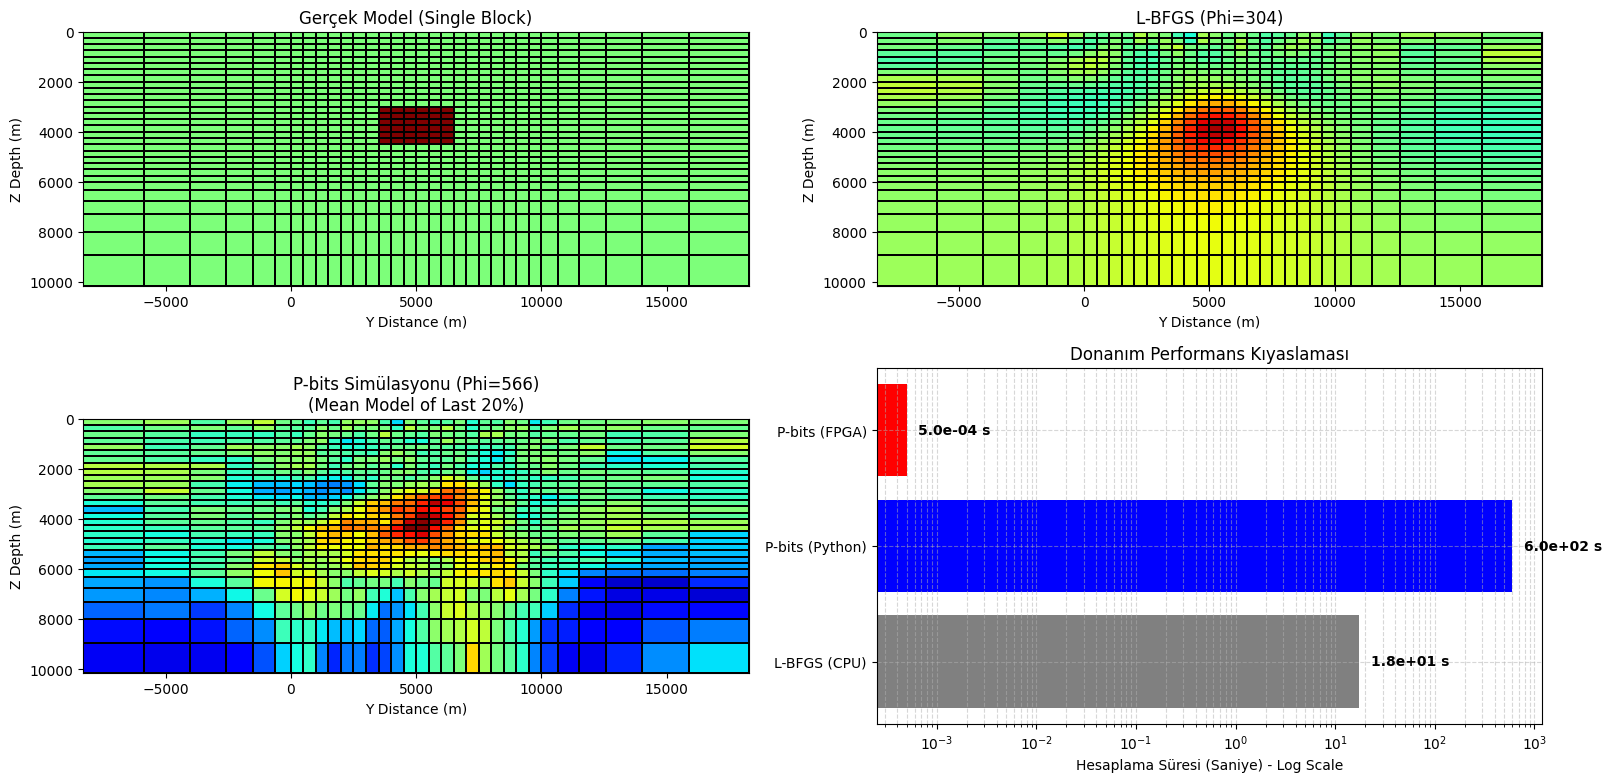

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import time


from pymtinv.forward import MT2DForward
from pymtinv.backward import MT2DGradient
from pymtinv.mesh import create_padded_mesh
from pymtinv.visualization import MT2DVisualizer


# --- 1. Tek Bloklu Basit Model ---
def create_single_block_model(mesh, n_pad_y):
    """
    Homojen arkaplan ortasında tek bir iletken blok.
    """
    # Arkaplan: 100 ohm-m (log = -2.0)
    sigma_log = np.ones((mesh.Ny, mesh.Nz)) * -2.0

    # Blok Konumu (Core bölgesinin ortası)
    cy = n_pad_y + (mesh.Ny - 2 * n_pad_y) // 2
    cz = mesh.Nz // 2

    # 10 ohm-m (log = -1.0) İletken Blok (4x4 hücre)
    sigma_log[cy - 3 : cy + 3, cz - 3 : cz + 3] = -1.0

    return sigma_log


# --- 2. P-bit Optimizer (AVERAGING EKLENDİ) ---
def pbit_optimizer_benchmark(
    grad_engine, m_init, freqs, mesh, n_steps, lr, t_start, t_end
):
    m_current = m_init.copy()

    # Averaging (Ortalama Alma) için hazırlık
    # Son %20'lik kısımdaki modelleri toplayıp ortalamasını alacağız.
    avg_start_step = int(n_steps * 0.8)
    m_sum = np.zeros_like(m_current)
    count_avg = 0

    best_m = m_current.copy()
    best_phi = 1e9

    print(f"   P-bit Progress: 0/{n_steps}", end="\r")

    for step in range(n_steps):
        # Cooling
        decay = (t_end / t_start) ** (step / n_steps)
        temp = t_start * decay

        # Gradient
        sigma_lin = 10 ** m_current.reshape((mesh.Ny, mesh.Nz))
        grad, phi = grad_engine.compute_gradient(freqs, sigma_lin, beta=5.0)  # Beta=5.0
        grad = grad.flatten()

        if phi < best_phi:
            best_phi = phi
            best_m = m_current.copy()

        # Update
        noise = np.sqrt(2 * temp) * np.random.randn(*m_current.shape)
        m_current += -lr * grad + noise
        m_current = np.clip(m_current, -4.0, 0.0)

        # --- AVERAGING MEKANİZMASI ---
        # Son %20'lik dilimde modelin "fotoğraflarını" üst üste bindiriyoruz
        if step >= avg_start_step:
            m_sum += m_current
            count_avg += 1

        if step % 100 == 0:
            print(f"   P-bit Progress: {step}/{n_steps} (Phi={phi:.1f})", end="\r")

    print(f"   P-bit Progress: {n_steps}/{n_steps} (Done)        ")

    # Ortalama Modeli Hesapla
    m_mean = m_sum / count_avg

    return m_mean, best_phi


def main():
    # --- AYARLAR ---
    N_PAD = 6
    mesh = create_padded_mesh(
        core_width=10000,
        core_depth=6000,
        core_dy=500,
        core_dz=250,
        pad_factor=1.3,
        n_pad_y=N_PAD,
        n_pad_z=N_PAD,
    )

    frequencies = np.logspace(2, -2.5, 10)

    # --- A. VERİ ÜRETİMİ ---
    print("\n [1/4] Veri Üretiliyor (Single Block)...")
    sigma_true_log = create_single_block_model(mesh, N_PAD)

    fwd = MT2DForward(mesh)
    Z_true, _ = fwd.solve_te(frequencies, 10**sigma_true_log)

    # %5 Gürültü
    Z_obs, data_std = [], []
    np.random.seed(42)
    for f in frequencies:
        val = Z_true[f]
        err = 0.05 * np.abs(val)
        Z_obs.append(
            val + err * (np.random.randn(*val.shape) + 1j * np.random.randn(*val.shape))
        )
        data_std.append(err)

    grad_engine = MT2DGradient(fwd, Z_obs, data_std)
    m_init = (np.ones((mesh.Ny, mesh.Nz)) * -2.0).flatten()
    bounds = [(-4, 0) for _ in range(len(m_init))]

    # --- B. L-BFGS (CPU) ---
    print("\n [2/4] L-BFGS (Klasik Yöntem) Çalışıyor...")
    start_cpu = time.time()

    def objective(m):
        sig = 10 ** m.reshape((mesh.Ny, mesh.Nz))
        g, p = grad_engine.compute_gradient(frequencies, sig, beta=5.0)  # Beta=5.0
        return p, g.flatten()

    res_lbfgs = minimize(
        objective,
        m_init,
        method="L-BFGS-B",
        jac=True,
        bounds=bounds,
        options={"maxiter": 60},
    )
    time_lbfgs = time.time() - start_cpu
    phi_lbfgs = res_lbfgs.fun
    m_lbfgs = res_lbfgs.x.reshape((mesh.Ny, mesh.Nz))
    print(f"   -> Süre: {time_lbfgs:.2f}s | Phi: {phi_lbfgs:.1f}")

    # --- C. P-BITS (PYTHON SIMULATION) ---
    # Python'da 3.000 adım atalım (Benchmark için)
    P_STEPS = 3000
    print(f"\n [3/4] P-bits Simülasyonu ({P_STEPS} adım)...")
    start_pbit = time.time()

    # DİKKAT: Artık ortalama alınmış (daha pürüzsüz) model dönüyor
    m_pbit_mean_flat, phi_pbit = pbit_optimizer_benchmark(
        grad_engine,
        m_init,
        frequencies,
        mesh,
        n_steps=P_STEPS,
        lr=0.002,
        t_start=0.1,
        t_end=0.001,
    )
    time_pbit_python = time.time() - start_pbit
    m_pbit = m_pbit_mean_flat.reshape((mesh.Ny, mesh.Nz))
    print(f"   -> Süre: {time_pbit_python:.2f}s | Best Phi: {phi_pbit:.1f}")

    # --- D. FPGA PROJEKSİYONU (TEORİK HESAP) ---
    # FPGA: 200 MHz Clock, Her adım 1 Cycle
    FPGA_CLOCK_NS = 5e-9

    # Adil karşılaştırma için: Gerçek senaryoda 100.000 adım
    REAL_P_STEPS = 100000
    time_fpga_theory = REAL_P_STEPS * FPGA_CLOCK_NS

    print(f"\n [4/4] Analiz Tamamlandı.")

    # --- GÖRSELLEŞTİRME ---
    plt.figure(figsize=(16, 8), constrained_layout=True)
    vmin, vmax = -3, -1

    # 1. Gerçek Model
    ax1 = plt.subplot(2, 2, 1)
    MT2DVisualizer.plot_model(
        mesh,
        sigma_true_log,
        ax=ax1,
        title="Gerçek Model (Single Block)",
        grid_lines=True,
        vmin=vmin,
        vmax=vmax,
    )

    # 2. L-BFGS Sonucu
    ax2 = plt.subplot(2, 2, 2)
    MT2DVisualizer.plot_model(
        mesh,
        m_lbfgs,
        ax=ax2,
        title=f"L-BFGS (Phi={phi_lbfgs:.0f})",
        grid_lines=True,
        vmin=vmin,
        vmax=vmax,
    )

    # 3. P-bits Sonucu (MEAN MODEL)
    ax3 = plt.subplot(2, 2, 3)
    MT2DVisualizer.plot_model(
        mesh,
        m_pbit,
        ax=ax3,
        title=f"P-bits Simülasyonu (Phi={phi_pbit:.0f})\n(Mean Model of Last 20%)",
        grid_lines=True,
        vmin=vmin,
        vmax=vmax,
    )

    # 4. Performans Bar Grafiği (LOG SCALE)
    ax4 = plt.subplot(2, 2, 4)
    times = [time_lbfgs, time_pbit_python, time_fpga_theory]
    labels = ["L-BFGS (CPU)", "P-bits (Python)", "P-bits (FPGA)"]
    colors = ["gray", "blue", "red"]

    bars = ax4.barh(labels, times, color=colors)
    ax4.set_xscale("log")  # Logaritmik skala
    ax4.set_xlabel("Hesaplama Süresi (Saniye) - Log Scale")
    ax4.set_title("Donanım Performans Kıyaslaması")
    ax4.grid(True, which="both", ls="--", alpha=0.5)

    # Değerleri yaz
    for bar, val in zip(bars, times):
        ax4.text(
            val * 1.3,
            bar.get_y() + bar.get_height() / 2,
            f"{val:.1e} s",
            va="center",
            fontweight="bold",
        )

    plt.show()


if __name__ == "__main__":
    main()


### Interpretation

Notice the "noisy" nature of the convergence graph in the early stages. This is a **feature**, not a bug. It represents the P-bits exploring the solution space. As the temperature drops (Annealing), the curve becomes smoother and settles into a minimum.

This approach allows us to find solutions that are robust and less dependent on the initial guess compared to deterministic methods.